## <center>Projeto AirBnb Berlim/Alemanha - Prevendo o preço dos imóveis<center/>

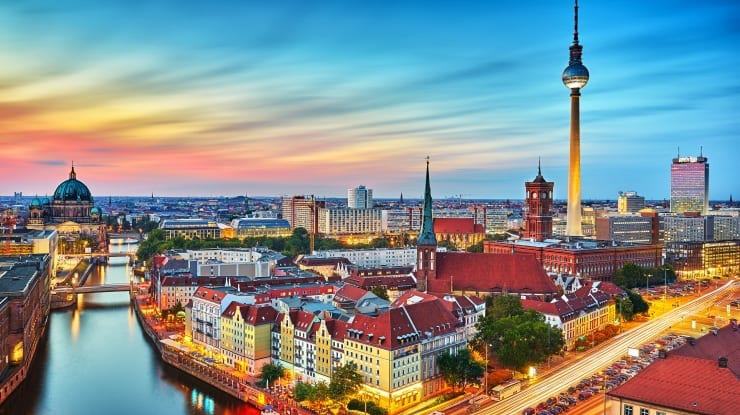

In [1]:
from PIL import Image
fig = Image.open('Berlim.jpeg')
display(Image.open('Berlim.jpeg'))

### Contexto

No Airbnb, qualquer pessoa que tenha um imóvel (casa, apartamento, chalé, pousada, etc.) ou até mesmo um quarto disponível, pode divulgar seu imóvel na plataforma. Basta criar um perfil no site e anunciar o imóvel para aluguel de diária.

Nesse anúncio, o host (quem anuncia o imóvel) deve descrever as características do imóvel da forma mais completa possível, para ajudar viajantes escolher o imóvel que mais lhe atrai.

Existem muitas opções para descrever o anúncio, desde preço, quantidade mínima de diária, quantidade de quartos, regras de cancelamento, host aceita pet, etc.

## Objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum (não rica) saber quanto deve cobrar pela diária do seu imóvel.
Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

Ou seja, imóveis grandes e caros serão tratados como outliers.

### Dados e informações

A base de dados utilizada é do trimestre 04/2021, 01/2022, 02/2022 e 03/2022. Ela não é disponibilizada mensalmente.

O Airbnb disponibiliza gratuitatamente a cada trimestre, porém não há como separar por mês. É possível comprar os dados de uma cidade e período desejado.

Link de onde baixei os dados: http://insideairbnb.com/get-the-data/

### Importando Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pathlib
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor

### Importando Bases de dados

In [3]:
semestres = {'pri': 1, 'seg': 2, 'ter': 3, 'qua': 4}

caminho_bases = pathlib.Path('basedados')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_semestre = arquivo.name[:3]
    semestre = semestres[nome_semestre]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['semestre'] = semestre 
    base_airbnb = base_airbnb.append(df)
    
display(base_airbnb)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ano,semestre,source
0,40218685,https://www.airbnb.com/rooms/40218685,20220320051227,2022-03-21,Ap 4 - Schönes Apartment nahe dem Helios Klinikum,Schwanenburg Apartments am Helios Klinikum - A...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,39450649,https://www.airbnb.com/users/show/39450649,...,NaN,t,21,20,1,0,0.40,2022,1,NaN
1,37849210,https://www.airbnb.com/rooms/37849210,20220320051227,2022-03-21,MODERN APARTMENT AT THE BERLIN WALL TRAIL,The location:<br />Right at the southern city ...,NaN,https://a0.muscache.com/pictures/797e3d16-06e6...,286623313,https://www.airbnb.com/users/show/286623313,...,NaN,f,1,1,0,0,0.07,2022,1,NaN
2,40218814,https://www.airbnb.com/rooms/40218814,20220320051227,2022-03-21,Ap 33 - Schöne Ferienwohnung am Helios Klinikum,Schwanenburg Apartments am Helios Klinikum - A...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,39450649,https://www.airbnb.com/users/show/39450649,...,NaN,t,21,20,1,0,0.16,2022,1,NaN
3,32431502,https://www.airbnb.com/rooms/32431502,20220320051227,2022-03-21,Marcella`s Ferienhaus westl. Stadtrand zu Berlin,Das gemütliche Ferienhaus liegt am westlichen ...,Falkensee ist eine Gartenstadt mit viel Grün. ...,https://a0.muscache.com/pictures/2a3908bf-8393...,243598169,https://www.airbnb.com/users/show/243598169,...,NaN,f,1,1,0,0,0.43,2022,1,NaN
4,546874411676130505,https://www.airbnb.com/rooms/546874411676130505,20220320051227,2022-03-21,Lake house getaway in nature reserve close to Bln,Take a break from the city in this cozy little...,Within 5 minutes walking distance you reach tw...,https://a0.muscache.com/pictures/miso/Hosting-...,156670608,https://www.airbnb.com/users/show/156670608,...,NaN,f,1,1,0,0,2.55,2022,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16675,2650812,https://www.airbnb.com/rooms/2650812,20220915162225,2022-09-16,Gäste-Zimmer ALEXA 2,Für den angenehmen Aufenthalt haben wir ein Ei...,NaN,https://a0.muscache.com/pictures/57614015/7b57...,13569320,https://www.airbnb.com/users/show/13569320,...,NaN,f,4,1,3,0,NaN,2022,3,city scrape
16676,39853201,https://www.airbnb.com/rooms/39853201,20220915162225,2022-09-16,"3-Zi-Wohnung am Dämeritzsee, Berlin, Brandenburg",Die 112qm große 3-Raum-EG-Wohnung liegt direkt...,"Es ist eine ruhige Wohnstrasse, meist mit Ein...",https://a0.muscache.com/pictures/675fbea4-7978...,89818386,https://www.airbnb.com/users/show/89818386,...,NaN,f,1,1,0,0,0.87,2022,3,city scrape
16677,2855881,https://www.airbnb.com/rooms/2855881,20220915162225,2022-09-16,Gäste-Zimmer ALEXA 4,Unser Zuhause in Schönblick bietet zusätzlich ...,Der Ortsteil Schönblick in Woltersdorf (Schleu...,https://a0.muscache.com/pictures/57599998/e8e1...,13569320,https://www.airbnb.com/users/show/13569320,...,NaN,f,4,1,3,0,NaN,2022,3,city scrape
16678,46313178,https://www.airbnb.com/rooms/46313178,20220915162225,2022-09-16,TESLA / Grünheide Wohnung hochwertig möbliert,Tolle neue hochwertig Design-möblierte Wohnung...,Sehr ruhige idyllische Straße mit netten Nachb...,https://a0.muscache.com/pictures/f2d8fdcd-4e6c...,87267772,https://www.airbnb.com/users/show/87267772,...,NaN,t,1,1,0,0,NaN,2022,3,city scrape


### Tratamento inicial da base

- Como há muitas colunas, o modelo pode acabar ficando lento.
- Além disso, com uma simples análise, percebi que várias colunas não são necessárias para esse modelo de previsão, por isso, excluí algumas colunas dessa base.
- Tipos de colunas excluídas:
    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês)
    3. Colunas preenchidas com texto livre - Não usarei análise de palavras
    4. Colunas em que todos ou quase todos os valores são iguais

In [4]:
print(list(base_airbnb.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficaram as seguintes colunas:

In [5]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_identity_verified','latitude','longitude','property_type','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','ano','semestre']

base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,ano,semestre
0,within an hour,100%,f,t,52.63136,13.51879,Holiday park,Entire home/apt,2,1 bath,...,4.45,4.27,4.91,4.55,4.73,4.18,4.09,t,2022,1
1,a few days or more,25%,f,t,52.37272,13.41607,Entire rental unit,Entire home/apt,4,1 bath,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,f,2022,1
2,within an hour,100%,f,t,52.63136,13.51879,Entire rental unit,Entire home/apt,4,1 bath,...,4.33,4.67,4.67,5.00,5.00,4.33,4.33,t,2022,1
3,within an hour,100%,f,t,52.55720,13.14205,Entire residential home,Entire home/apt,3,1 bath,...,4.81,4.88,4.69,5.00,5.00,4.88,4.75,f,2022,1
4,within a few hours,75%,f,t,52.45472,13.10890,Entire cottage,Entire home/apt,5,1 bath,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,f,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16675,within a few hours,100%,f,t,52.45776,13.72540,Private room in home,Private room,3,1 bath,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,2022,3
16676,within a few hours,100%,t,t,52.41807,13.74173,Entire rental unit,Entire home/apt,4,1 bath,...,5.00,5.00,4.96,5.00,5.00,5.00,4.70,f,2022,3
16677,within a few hours,100%,f,t,52.45965,13.72548,Private room in home,Private room,6,1 bath,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,2022,3
16678,within a day,89%,f,t,52.46061,13.69917,Entire rental unit,Entire home/apt,2,1 bath,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,2022,3


### Significado das colunas que serão usadas

- host_is_superhost = o proprietário do imóvel é visto como um bom anfitrião.
- host_identity_verified = identidade do proprietário é verificada pelo Airbnb, ou seja, é real.
- latitude = coordenada geográfica.
- longitude = coordenada geográfica.
- property_type = tipo de propriedade. Ex: hotel, pousada, quarto em apartamento, etc.
- room_type = os imóveis são agrupados em: imóvel inteiro, quarto privado e quarto compartilhado.
- accommodates = capacidade máxima de pessoas acomodadas.
- bathrooms_text = quantidade de banheiros, porém, não é mais coluna numérica, agora é textual, para detalhar bem a situação.
- bedrooms = número de quartos.
- beds = número de camas.
- amenities = comodidades, facilidades. Ex: Wi-fi, ar-condicionado, TV, elevador, etc.
- price = valor da diária. Está em moeda local, ou seja, Euros.
- minimum_nights = mínimo de noites para alugar. Alguns proprietários colocam mínimo de dias para alugar seu imóvel.
- number_of_reviews = número de avaliações recebidas pelo proprietário.
- instant_bookable = disponível para reserva imediatamente. Ex: alguns hosts verificam quem está reservando antes de aceitar.
- ano = ano dos dados.
- semestre = semestre do ano. O Airbnb disponibiliza gratuitamente seus dados apenas trimestralmente.

### Tratamento de valores faltantes

- Analisando os dados, nota-se que existe uma grande disparidade em dados faltantes. As colunas com mais de 12.000 valores NaN foram excluídas da análise
- Para as outras colunas, vou excluir as linhas que contém dados NaN, pois são poucas linhas.

In [6]:
print(base_airbnb.isnull().sum())

host_response_time             35306
host_response_rate             35306
host_is_superhost                 39
host_identity_verified            51
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms_text                    85
bedrooms                        5616
beds                            1486
amenities                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
review_scores_rating           12136
review_scores_accuracy         13252
review_scores_cleanliness      13244
review_scores_checkin          13298
review_scores_communication    13255
review_scores_location         13294
review_scores_value            13302
instant_bookable                   0
ano                                0
semestre                           0
dtype: int64


In [7]:
print(base_airbnb.shape)

(67348, 26)


In [8]:
# Excluindo colunas com valores ausentes maiores que 6000

for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 6000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost           39
host_identity_verified      51
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
bathrooms_text              85
bedrooms                  5616
beds                      1486
amenities                    0
price                        0
minimum_nights               0
number_of_reviews            0
instant_bookable             0
ano                          0
semestre                     0
dtype: int64


#### - bedrooms
- Os quartos (bedrooms) há um número razoável (5616) de dados NaN. Numa rápida análise, vi que quase 73% dos imóveis têm 1 quarto, já o acumulado de 1 e 2 quartos, possuem 87%.
- Usei 1.0 como média para os dados NaN, porém o modelo de previsão ficou pior. Assim, decidi excluir esses valores NaN.


- Fica também como uma curiosidade, 87% dos quartos disponíveis no Airbnb em Berlim têm 1 ou 2 quartos.

In [9]:
# Excluindo linhas com dados faltantes. Como não eram muitas linhas, optei por excluir

base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(60336, 17)
host_is_superhost         0
host_identity_verified    0
latitude                  0
longitude                 0
property_type             0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
price                     0
minimum_nights            0
number_of_reviews         0
instant_bookable          0
ano                       0
semestre                  0
dtype: int64


### Verificando o tipo de dados em cada coluna

In [10]:
print(base_airbnb.dtypes)
print('-'*80)
print(base_airbnb.iloc[0])

host_is_superhost          object
host_identity_verified     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
bathrooms_text             object
bedrooms                  float64
beds                      float64
amenities                  object
price                      object
minimum_nights              int64
number_of_reviews           int64
instant_bookable           object
ano                         int64
semestre                    int64
dtype: object
--------------------------------------------------------------------------------
host_is_superhost                                                         f
host_identity_verified                                                    t
latitude                                                           52.63136
longitude                                                          13.51879
property_type          

### Como o preço "price" está como objeto (ao invés de ser um float) é necessário mudar o tipo de variável da coluna.

In [11]:
# Price

base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float64, copy=False)

# Verificando os tipos

print(base_airbnb.dtypes)

host_is_superhost          object
host_identity_verified     object
latitude                  float64
longitude                 float64
property_type              object
room_type                  object
accommodates                int64
bathrooms_text             object
bedrooms                  float64
beds                      float64
amenities                  object
price                     float64
minimum_nights              int64
number_of_reviews           int64
instant_bookable           object
ano                         int64
semestre                    int64
dtype: object


<ipython-input-11-a7ae002861e3>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')


### Análise Exploratória e Tratando Outliers

- Analisarei feature por feature para:
    1. Ver a correlação entre as features e decidir se mantenho todas as features no dataset.
    2. Excluir outliers (usarei como regra, valores abaixo de Q1 - 1.5x Amplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Analisar se todas as features fazem realmente sentido para o modelo ou se alguma delas não irá ajudar, assim será excluída.
    
    
- Iniciando pela coluna de preço (resultado final).

- Em seguida, as colunas de valores numéricos discretos (accomodates, bedrooms, beds, etc.)

- Por fim, as colunas de texto e definir quais categorias fazem sentido manter.

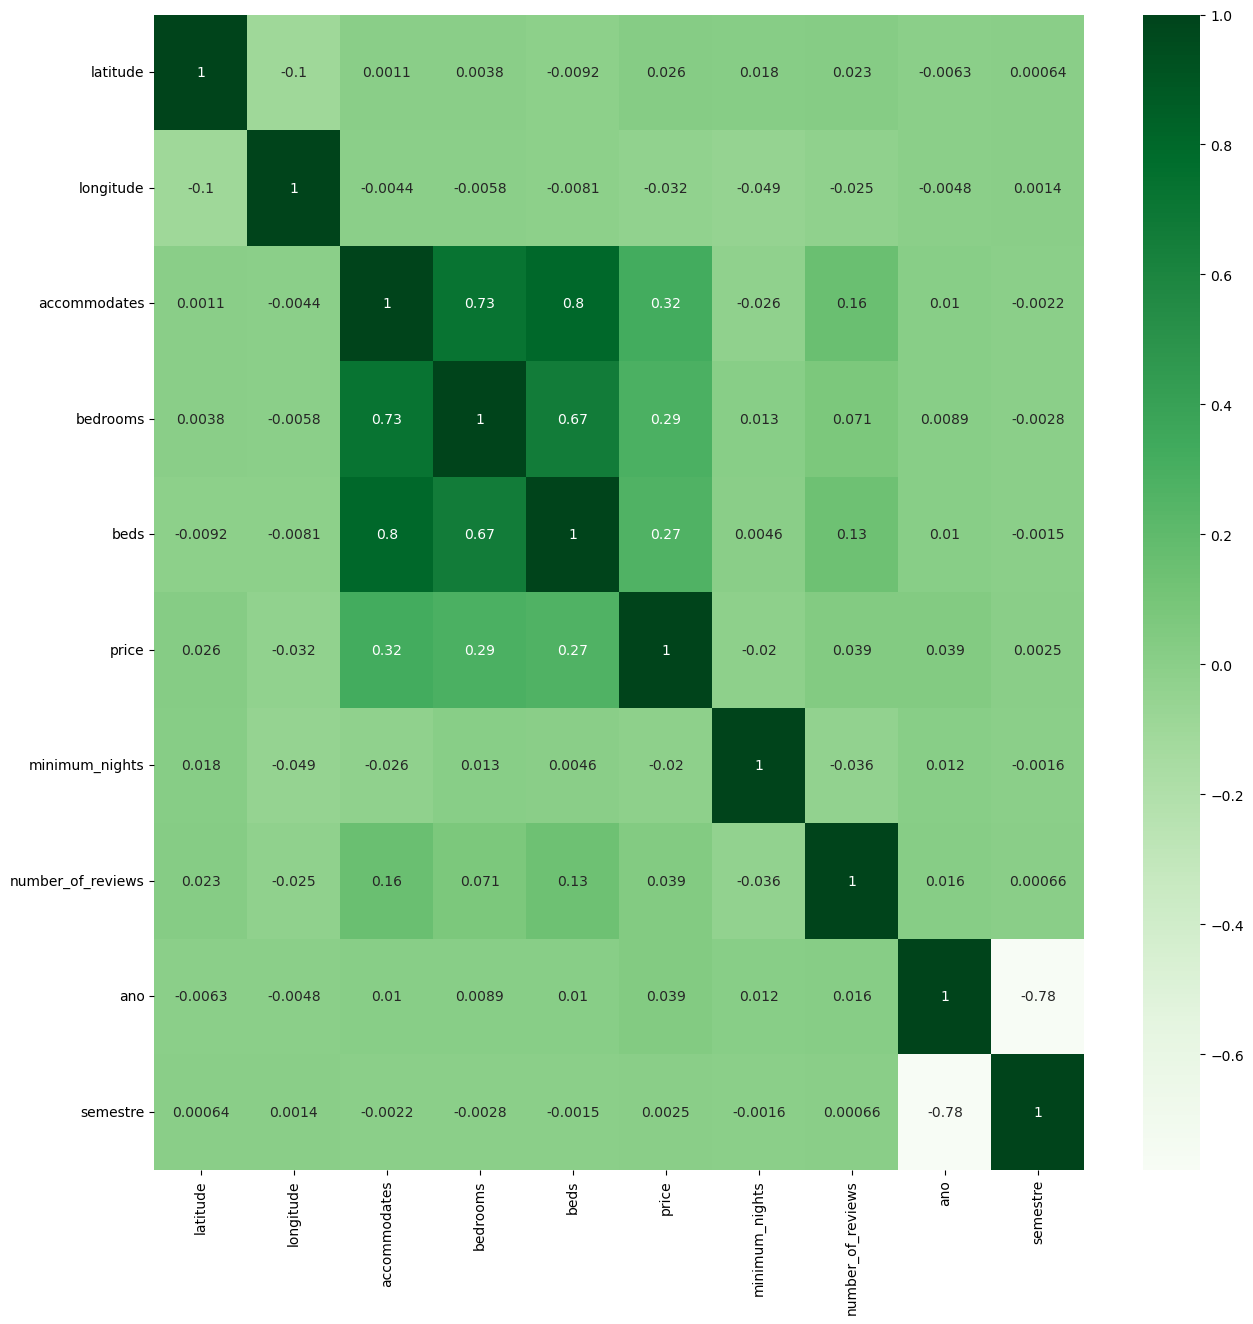

In [12]:
plt.figure(figsize=(15, 15))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')
plt.show()

### Definição de Funções para Análise de Outliers

Definindo algumas funções para ajudar na análise de outliers das colunas

In [13]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - (1.5 * amplitude), q3 + (1.5 * amplitude)

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

In [14]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)

def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Price

C:\Users\regis\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


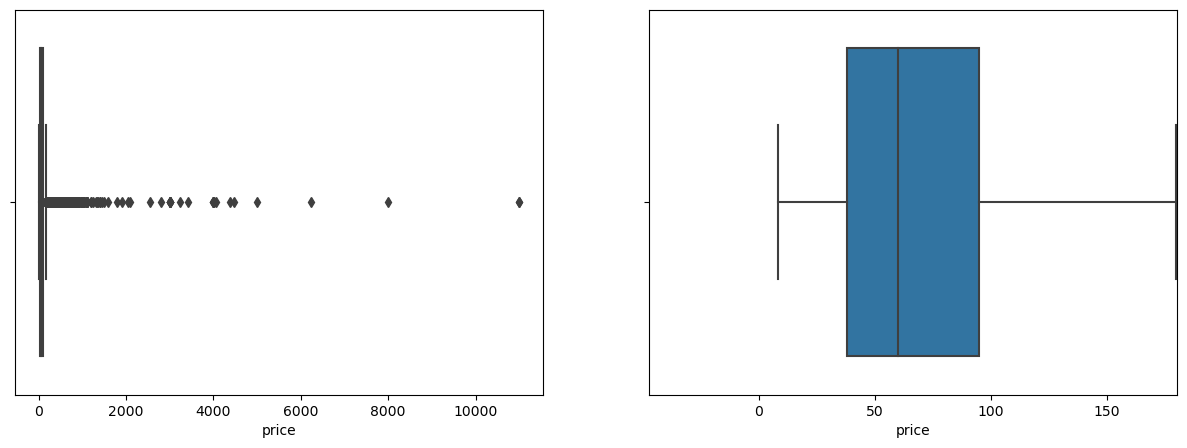

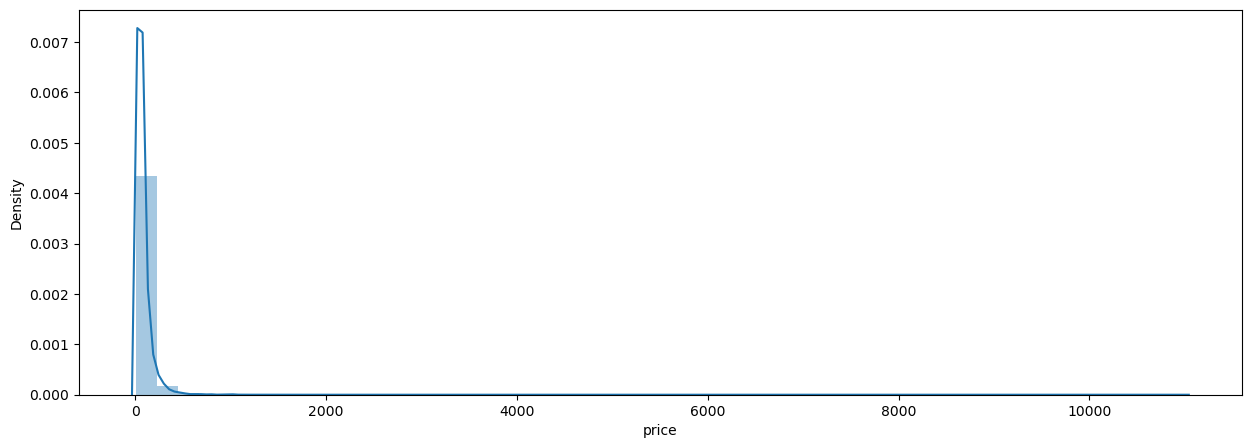

In [15]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])
plt.show()

 - Analisando o dataset, havia valores abaixo do normal, para imóveis inteiros. Assim, decidi excluir valores menores que 22 e maiores que 380, pois havia um número razoável de imóveis com valores que seriam superiores ao outlier acima no gráfico (200)

In [16]:
base_airbnb = base_airbnb[(base_airbnb['price']>=22 ) & (base_airbnb['price'] <= 380)]
base_airbnb.head()

,host_is_superhost,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,instant_bookable,ano,semestre
0,f,t,52.63136,13.51879,Holiday park,Entire home/apt,2,1 bath,1.0,1.0,"[""Hair dryer"", ""Bed linens"", ""Stove"", ""Clothin...",51.0,1,11,t,2022,1
1,f,t,52.37272,13.41607,Entire rental unit,Entire home/apt,4,1 bath,1.0,2.0,"[""Bathtub"", ""Stove"", ""Patio or balcony"", ""Sing...",40.0,28,2,f,2022,1
2,f,t,52.63136,13.51879,Entire rental unit,Entire home/apt,4,1 bath,2.0,3.0,"[""Hair dryer"", ""Bed linens"", ""Bathtub"", ""Stove...",87.0,1,3,t,2022,1
3,f,t,52.55720,13.14205,Entire residential home,Entire home/apt,3,1 bath,1.0,4.0,"[""Stove"", ""Patio or balcony"", ""Iron"", ""Single ...",55.0,3,16,f,2022,1
4,f,t,52.45472,13.10890,Entire cottage,Entire home/apt,5,1 bath,2.0,3.0,"[""Hair dryer"", ""Carbon monoxide alarm"", ""Lockb...",90.0,3,4,f,2022,1


### accommodates

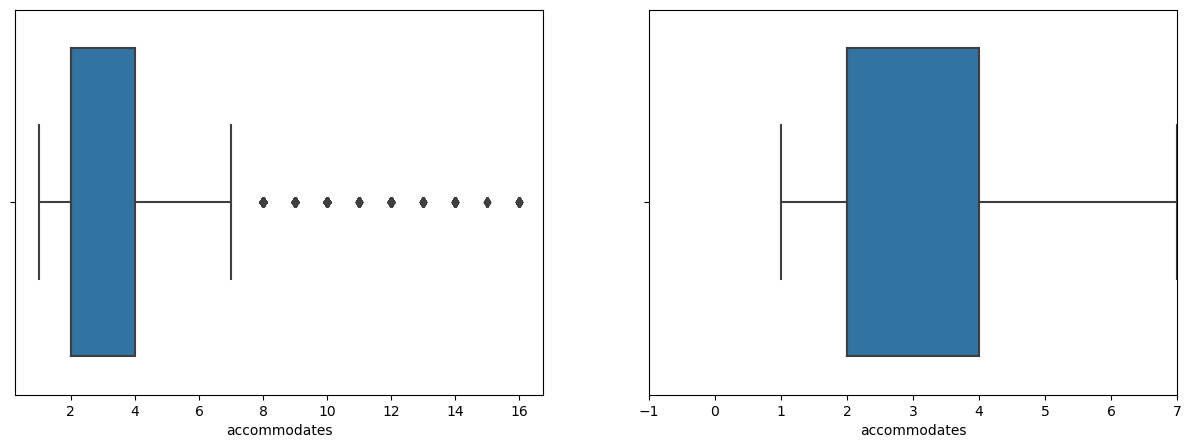

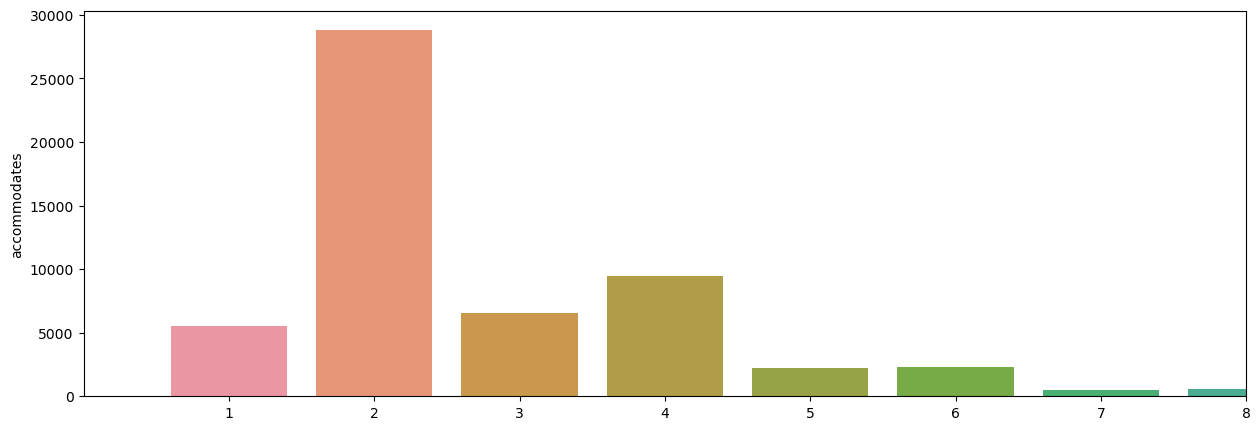

In [17]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])
plt.show()

- Como a maioria dos imóveis tem até 2 quartos e o gráficou indicou que mais de 7 pessoas já é um outlier, excluí os outliers.

In [18]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

1114 linhas removidas


### bedrooms 

C:\Users\regis\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


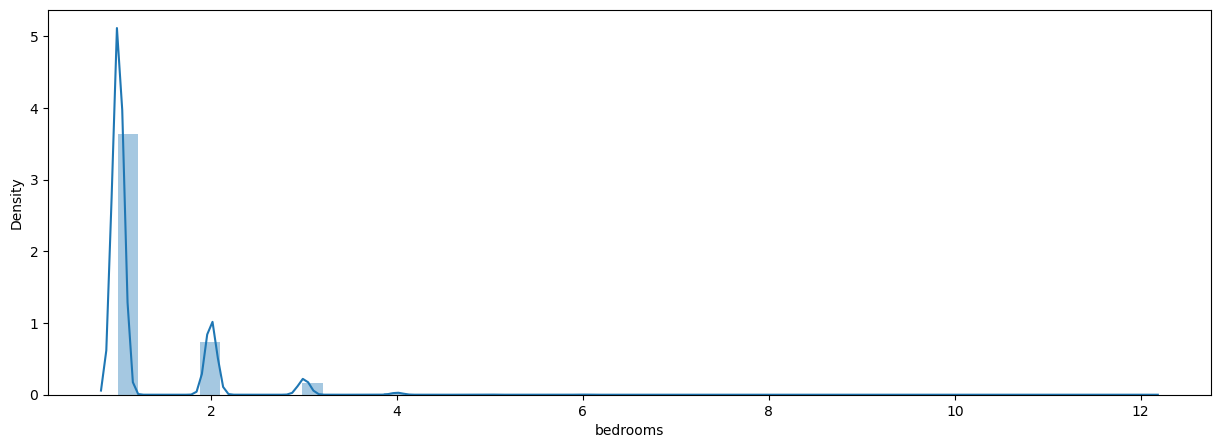

In [19]:
histograma(base_airbnb['bedrooms'])
plt.show()

- Como mencionado acima, 87% dos imóveis em Berlim disponíveis no Airbnb têm até 2 quartos. Apenas 3% têm 3 quartos, mas não tratei 3 quartos como outlier.

### beds

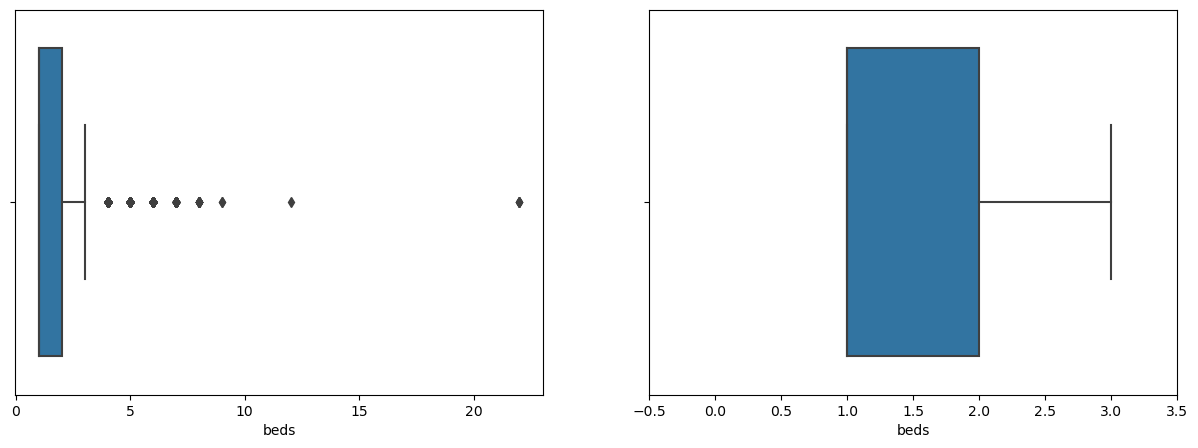

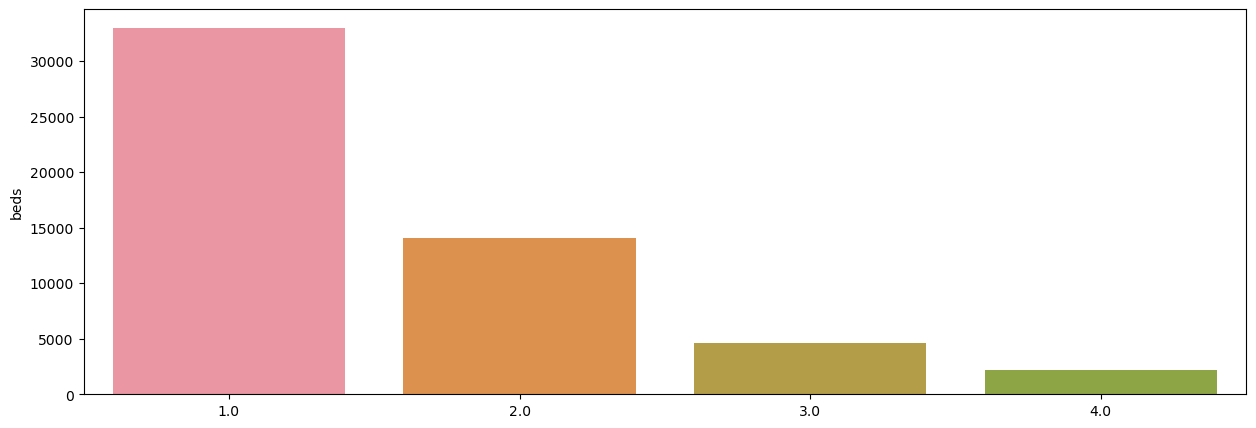

In [20]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])
plt.show()

In [21]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

3627 linhas removidas


- Conforme o gráfico, mais de 3 camas é um outlier. Assim, a partir de 4 camas foram tratadas como outliers e removidas.


- Vale lembrar que o modelo é para pessoas comuns (não afortunadas), por isso imóveis de alto padrão não fazem parte deste modelo de previsão de preços.

### minimum_nights

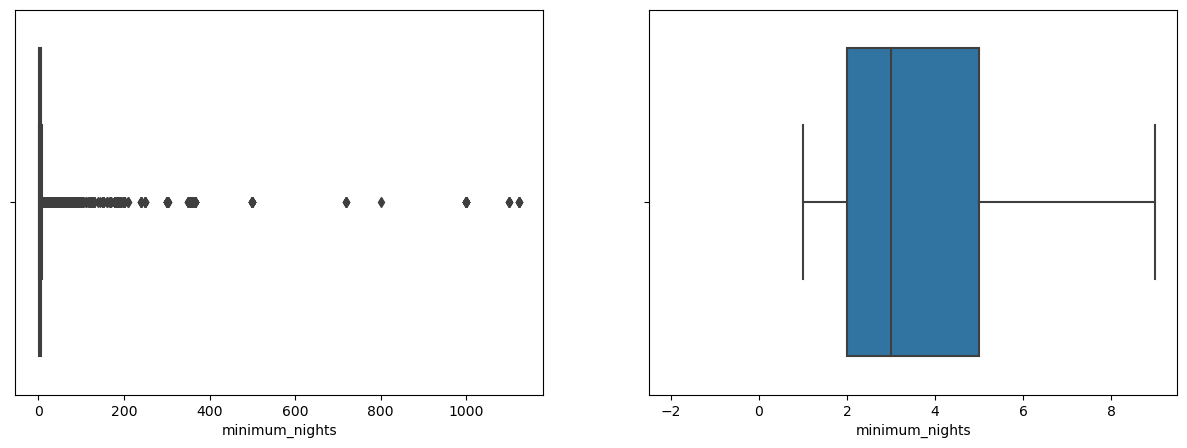

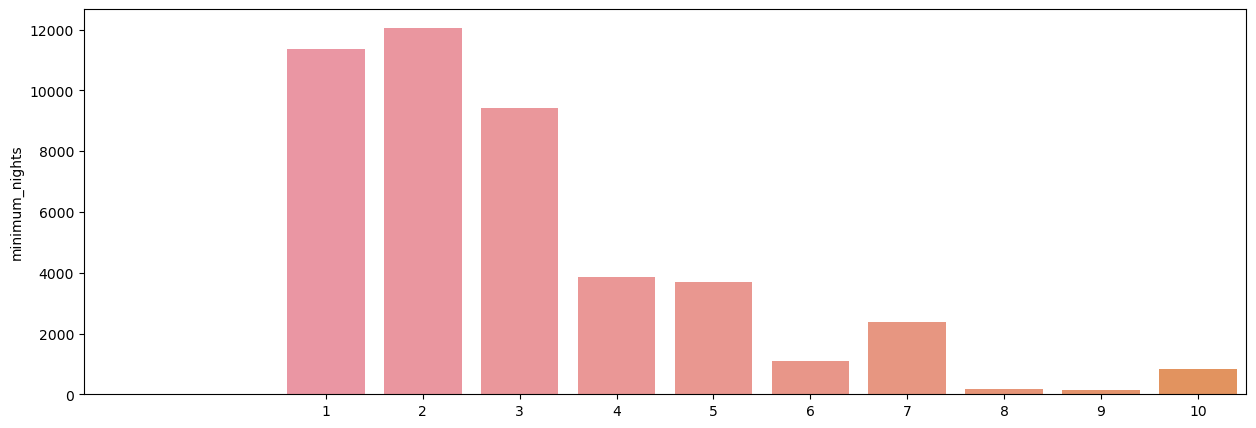

In [22]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])
plt.show()

- Usei mínimo de noites até 2 diárias, pois é um número bastante representativo. Além disso, por se tratar de um preenchimento manual, há bastante divergências na base de dados. Ex: exigir mínimo de 5, 10, 20, 50, 100 dias, etc.

In [23]:
min_nigh  = base_airbnb['minimum_nights'] <= 2
base_airbnb_2 = base_airbnb[min_nigh]

### number_of_reviews

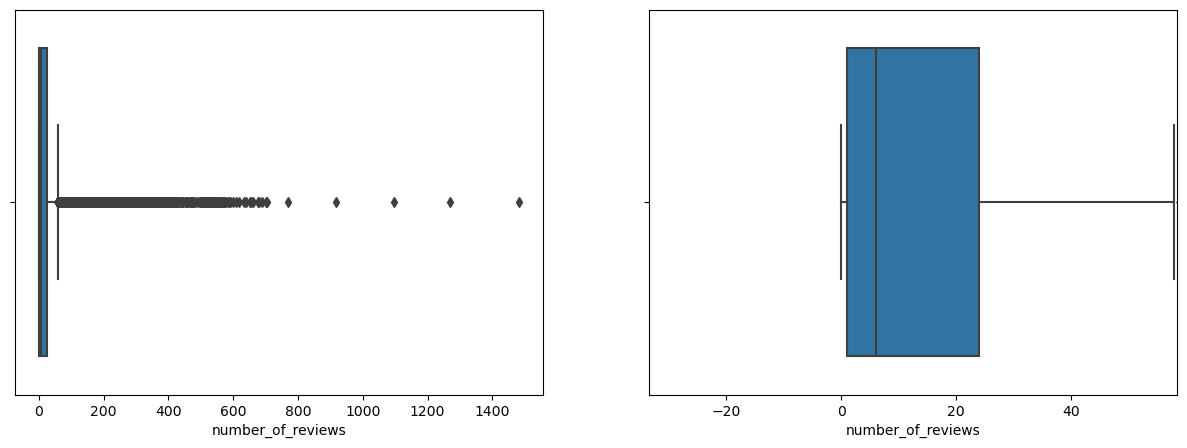

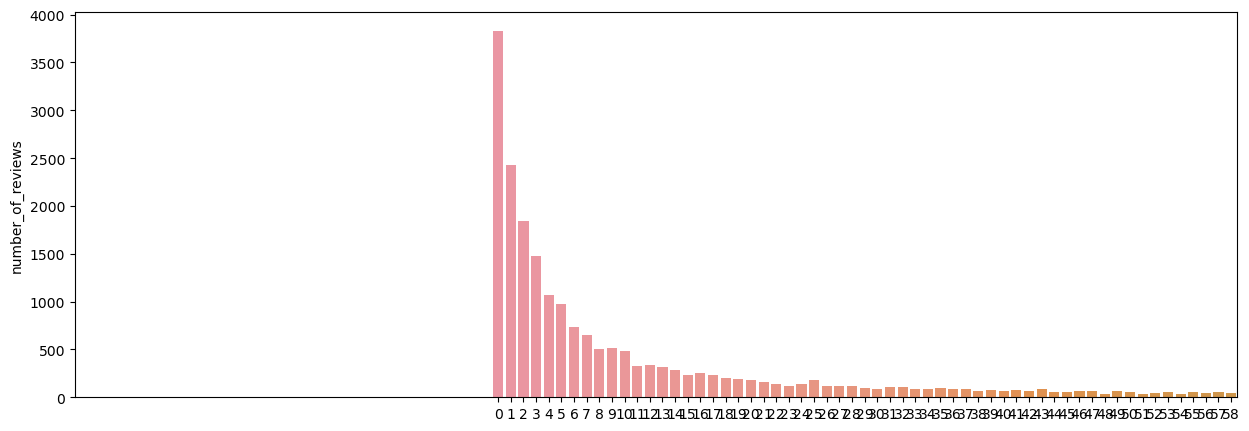

In [24]:
diagrama_caixa(base_airbnb_2['number_of_reviews'])
grafico_barra(base_airbnb_2['number_of_reviews'])
plt.show()

- Resolvi deixar o número de avaliações no modelo, apesar de um usuário novo não ter avaliação ou bem pouca, esse modelo serve para qualquer usuário calcular o preço da diária. Além disso, o modelo se saiu melhor sem excluir os outliers.

### Tratamento de Colunas de Valores de Texto

### property_type 

Private room in rental unit         10071
Entire rental unit                   8574
Room in hotel                         602
Entire serviced apartment             544
Private room in residential home      288
                                    ...  
Shared room in residential home         2
Shared room                             2
Holiday park                            1
Shared room in home                     1
Private room in minsu                   1
Name: property_type, Length: 63, dtype: int64


C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


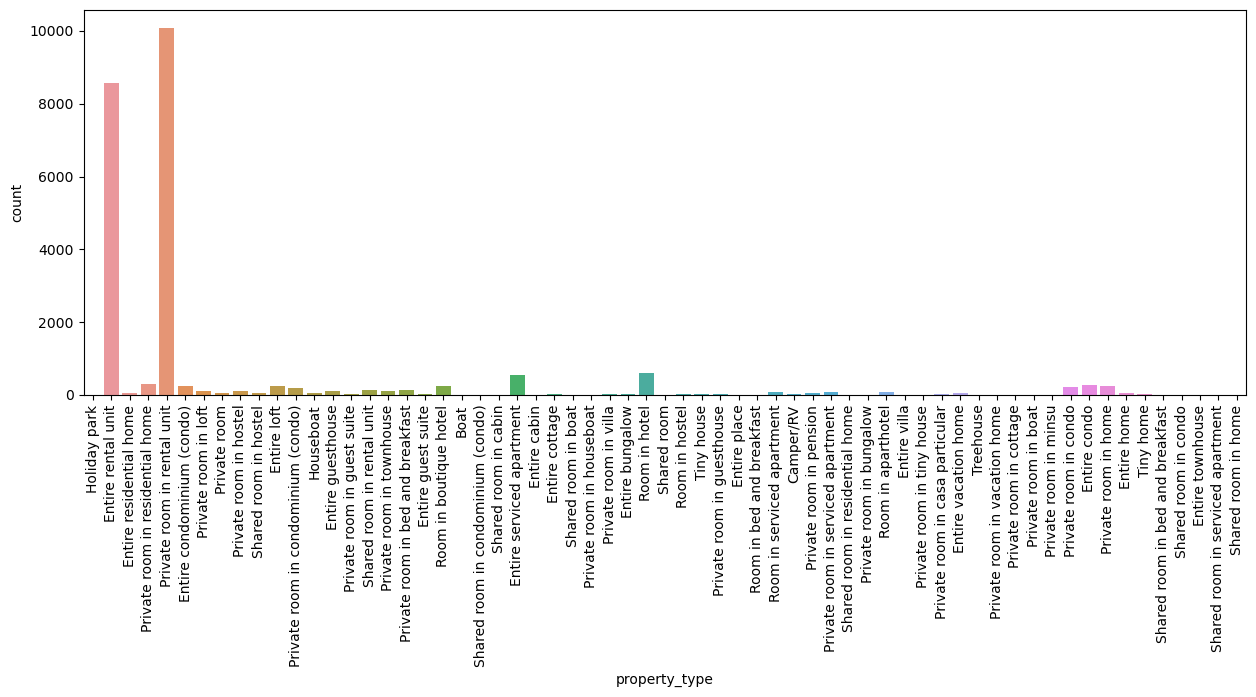

In [25]:
print(base_airbnb_2['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90) 
plt.show()

['Private room in residential home', 'Entire condo', 'Room in boutique hotel', 'Private room in home', 'Entire loft', 'Entire condominium (condo)', 'Private room in condo', 'Private room in condominium (condo)', 'Private room in bed and breakfast', 'Shared room in rental unit', 'Private room in hostel', 'Private room in loft', 'Private room in townhouse', 'Entire guesthouse', 'Room in aparthotel', 'Private room in serviced apartment', 'Room in serviced apartment', 'Private room', 'Entire home', 'Entire vacation home', 'Shared room in hostel', 'Entire residential home', 'Houseboat', 'Private room in pension', 'Entire bungalow', 'Entire guest suite', 'Room in hostel', 'Private room in villa', 'Private room in casa particular', 'Tiny home', 'Private room in guest suite', 'Camper/RV', 'Private room in guesthouse', 'Tiny house', 'Entire cottage', 'Private room in vacation home', 'Private room in bungalow', 'Boat', 'Private room in houseboat', 'Entire cabin', 'Private room in boat', 'Shared 

C:\Users\regis\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


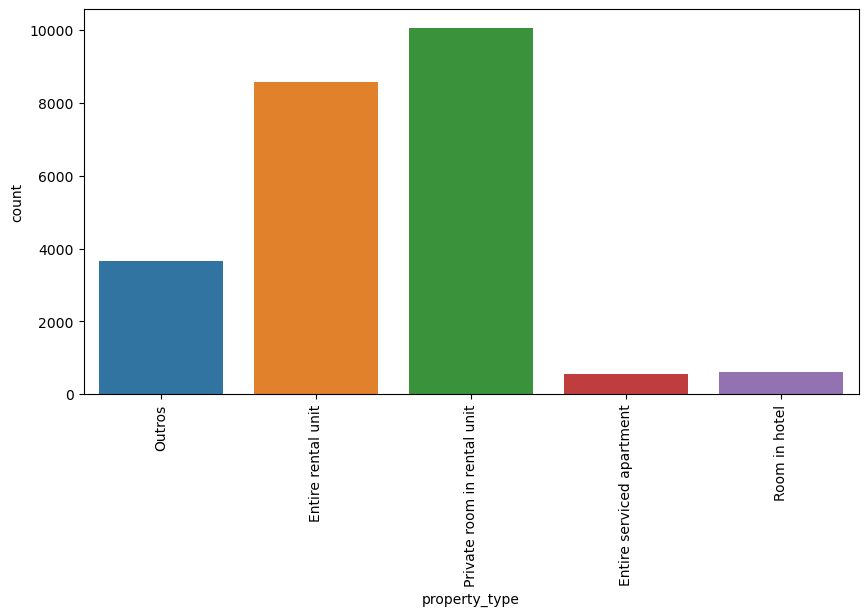

In [26]:
tabela_tipos_casa = base_airbnb_2['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 500:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_2.loc[base_airbnb_2['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb_2['property_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot('property_type', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90)
plt.show()

- Não excluí outliers, agrupei valores que são muito pequenos.

- Propriedadse que têm menos de 500 na base de dados, agrupei em um grupo chamado "outros".

## room_type 

Private room       12404
Entire home/apt    10438
Hotel room           392
Shared room          209
Name: room_type, dtype: int64


C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


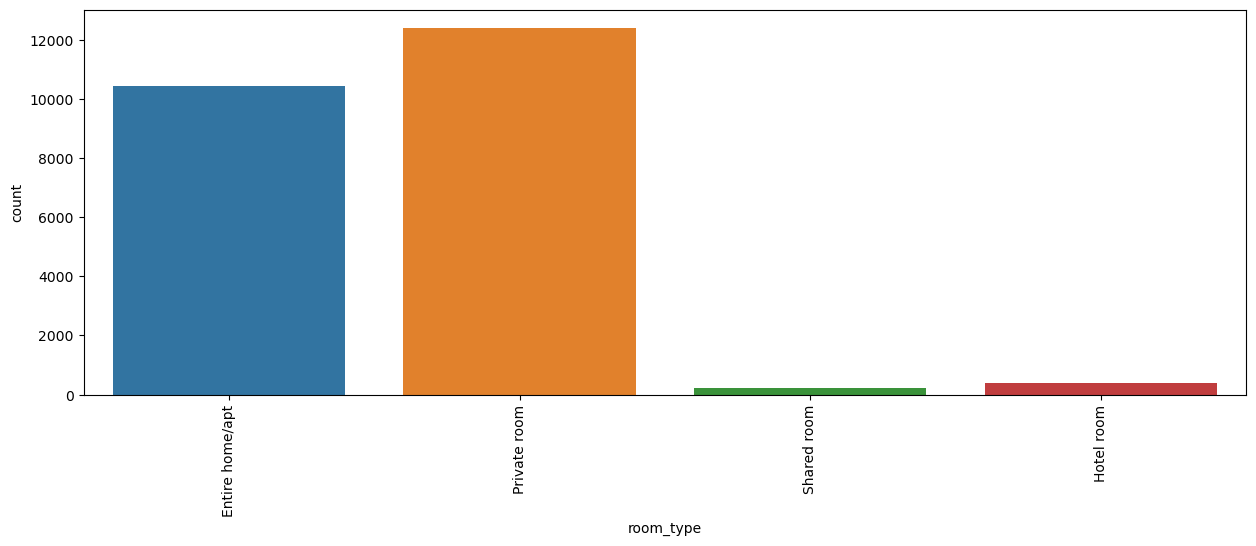

In [27]:
print(base_airbnb_2['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90) # para deixar todos os títulos na vertical
plt.show()

['Hotel room', 'Shared room']
Private room       12404
Entire home/apt    10438
Outros               601
Name: room_type, dtype: int64


C:\Users\regis\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


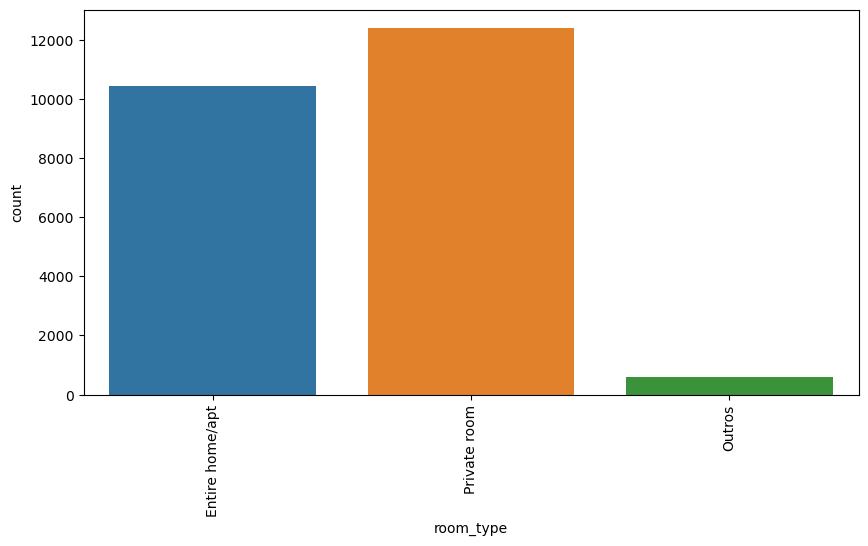

In [28]:
tabela_tipos_banheiro = base_airbnb_2['room_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_banheiro.index:
    if tabela_tipos_banheiro[tipo] < 500:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_2.loc[base_airbnb_2['room_type']==tipo, 'room_type'] = 'Outros'

print(base_airbnb_2['room_type'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot('room_type', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90)
plt.show()

- Room_type tb não excluí outliers, agrupei valores que são muito pequenos.

- Tipos de quarto que têm menos de 500 na base de dados, agrupei em um grupo chamado "outros".

### amenities  

- Como Há uma diversidade muito grande de amenities e, às vezes, as mesmas podem ser descritas diferente, cada item será um valor numérico, assim, quanto mais itens, teoricamente o imóvel terá mais comodidades

In [29]:
print(base_airbnb_2['amenities'].iloc[1].split(','))
print(len(base_airbnb_2['amenities'].iloc[1].split(',')))

base_airbnb_2['n_amenities'] = base_airbnb_2['amenities'].str.split(',').apply(len)

['["Hair dryer"', ' "Bed linens"', ' "Bathtub"', ' "Stove"', ' "Oven"', ' "Patio or balcony"', ' "Free washer \\u2013 In building"', ' "Clothing storage: wardrobe"', ' "Security cameras on property"', ' "Dining table"', ' "Lockbox"', ' "Long term stays allowed"', ' "Baking sheet"', ' "Free parking on premises"', ' "Refrigerator"', ' "Free street parking"', ' "Cooking basics"', ' "Heating"', ' "Wifi"', ' "Microwave"', ' "Dedicated workspace"', ' "Coffee maker"', ' "Smoke alarm"', ' "Luggage dropoff allowed"', ' "Hangers"', ' "Extra pillows and blankets"', ' "Essentials"', ' "Hot water kettle"', ' "Hot water"', ' "TV"', ' "Private entrance"', ' "Kitchen"', ' "Dishes and silverware"]']
33


<ipython-input-29-c97141596607>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_airbnb_2['n_amenities'] = base_airbnb_2['amenities'].str.split(',').apply(len)


In [30]:
base_airbnb_2 = base_airbnb_2.drop('amenities', axis=1)
base_airbnb_2.shape

(23443, 17)

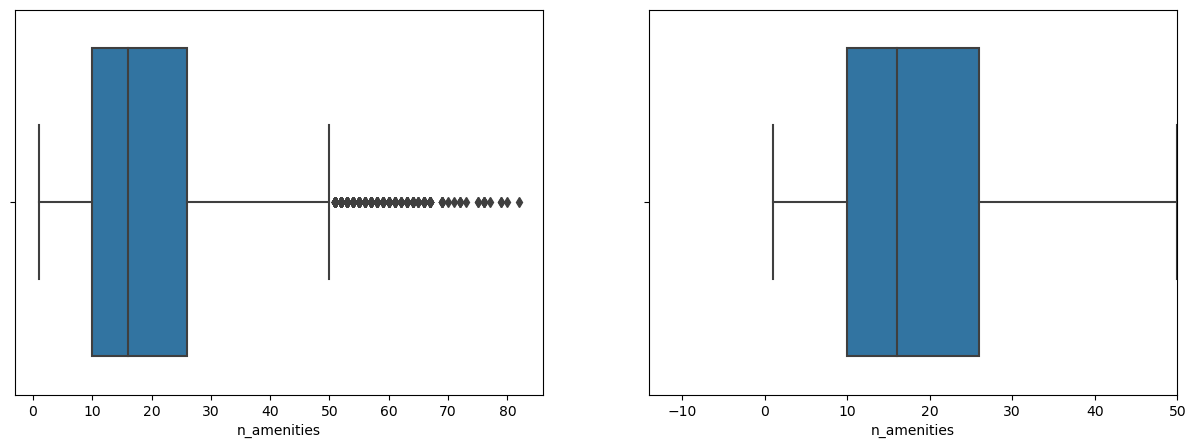

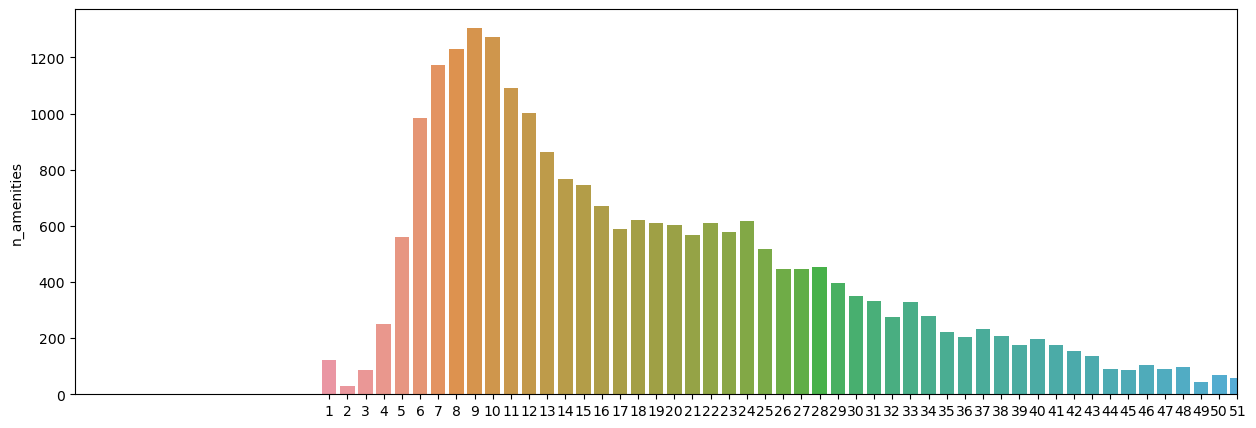

In [31]:
diagrama_caixa(base_airbnb_2['n_amenities'])
grafico_barra(base_airbnb_2['n_amenities'])
plt.show()

In [32]:
base_airbnb_2, linhas_removidas = excluir_outliers(base_airbnb_2, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

392 linhas removidas


- Como dito acima, virou uma coluna de valor numérico e excluí os outliers da mesma maneira que já foram removidos acima.

### bathrooms_text

- Atualmente, o AirBnb não disponibiliza mais "banheiro" como valor numérico. Agora é em formato de texto, podendo personalizá-lo.


- Então, tratei essa feature como de texto, como as outras acima.

1 bath               11838
1 shared bath         6850
1 private bath        1854
1.5 baths              778
1.5 shared baths       641
2 baths                478
2 shared baths         338
2.5 baths               60
Half-bath               55
0 shared baths          54
2.5 shared baths        26
0 baths                 24
Shared half-bath        23
3 baths                 11
Private half-bath        5
4 baths                  4
8 baths                  4
7 baths                  4
4.5 shared baths         3
4 shared baths           1
Name: bathrooms_text, dtype: int64


C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


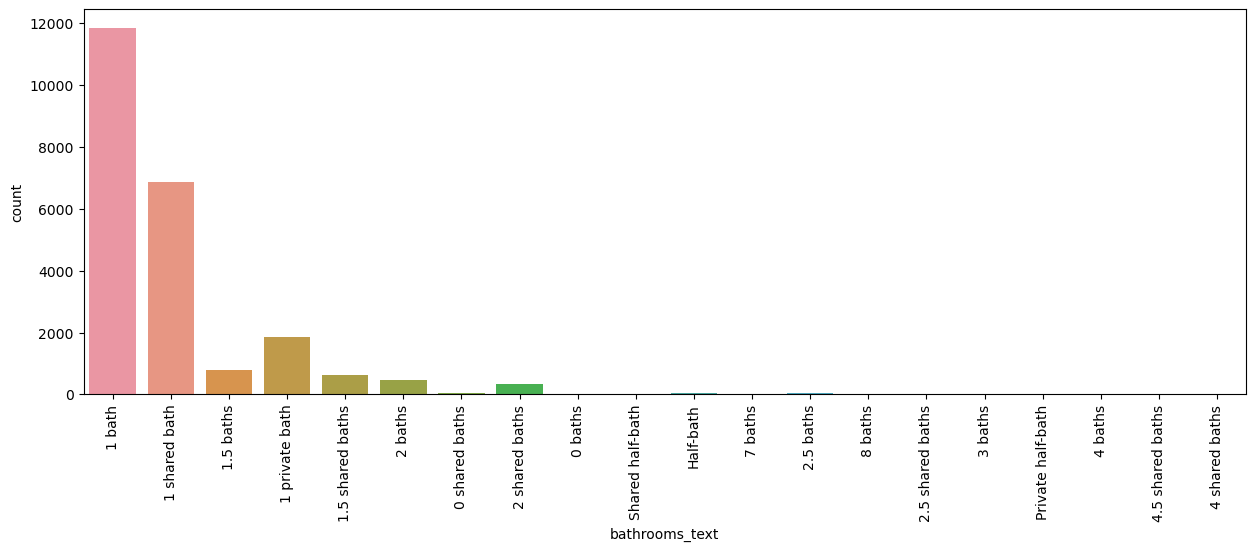

In [33]:
print(base_airbnb_2['bathrooms_text'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bathrooms_text', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90) # para deixar todos os títulos na vertical
plt.show()

['2 baths', '2 shared baths', '2.5 baths', 'Half-bath', '0 shared baths', '2.5 shared baths', '0 baths', 'Shared half-bath', '3 baths', 'Private half-bath', '4 baths', '8 baths', '7 baths', '4.5 shared baths', '4 shared baths']
1 bath              11838
1 shared bath        6850
1 private bath       1854
Outros               1090
1.5 baths             778
1.5 shared baths      641
Name: bathrooms_text, dtype: int64


C:\Users\regis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


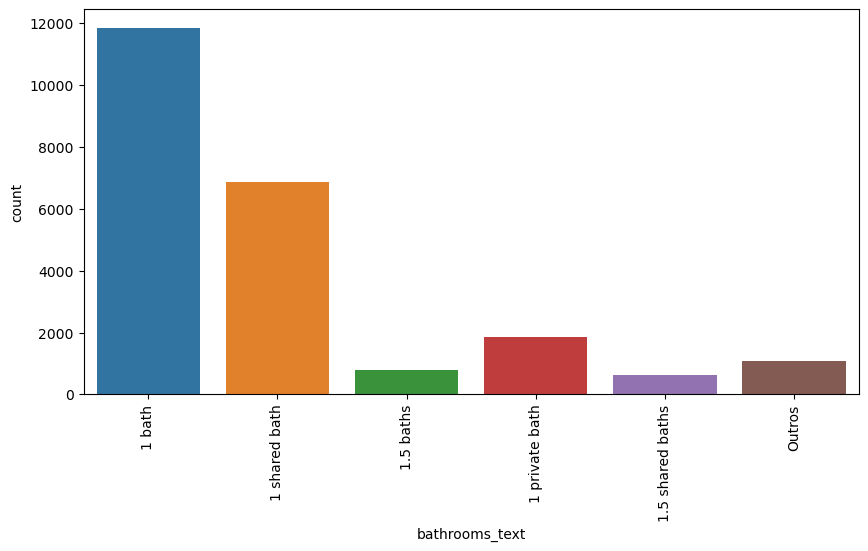

In [34]:
tabela_tipos_banheiro = base_airbnb_2['bathrooms_text'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_banheiro.index:
    if tabela_tipos_banheiro[tipo] < 500:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_2.loc[base_airbnb_2['bathrooms_text']==tipo, 'bathrooms_text'] = 'Outros'

print(base_airbnb_2['bathrooms_text'].value_counts())
plt.figure(figsize=(10, 5))
grafico = sns.countplot('bathrooms_text', data=base_airbnb_2)
grafico.tick_params(axis='x', rotation=90)
plt.show()

### Visualização de Mapa das Propriedades


Criando um mapa que exibe uma parte da base de dados aleatória (10.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais com maior preço.

In [1]:
amostra = base_airbnb_2.sample(n=10000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=5.1,
                        center=centro_mapa, zoom=11,
                       mapbox_style='stamen-terrain', width=800, height=600)
mapa.show()

NameError: name 'base_airbnb_2' is not defined

### Encoding

Ajustando as features para facilitar o trabalho do modelo (features de categoria, true e false, etc.)

- Features de Valores True ou False, substití True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) utilizei o método de encoding de variáveis dummies.

In [36]:
colunas_tf = ['host_is_superhost', 'host_identity_verified', 'instant_bookable'] 
base_airbnb_cod = base_airbnb_2.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

In [37]:
colunas_categorias = ['property_type','room_type', 'bathrooms_text']

base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,number_of_reviews,...,property_type_Room in hotel,room_type_Entire home/apt,room_type_Outros,room_type_Private room,bathrooms_text_1 bath,bathrooms_text_1 private bath,bathrooms_text_1 shared bath,bathrooms_text_1.5 baths,bathrooms_text_1.5 shared baths,bathrooms_text_Outros
0,0,1,52.63136,13.51879,2,1.0,1.0,51.0,1,11,...,0,1,0,0,1,0,0,0,0,0
2,0,1,52.63136,13.51879,4,2.0,3.0,87.0,1,3,...,0,1,0,0,1,0,0,0,0,0
5,0,1,52.63136,13.51879,4,2.0,3.0,87.0,1,2,...,0,1,0,0,1,0,0,0,0,0
6,0,1,52.63150,13.51887,2,1.0,2.0,75.0,1,5,...,0,1,0,0,1,0,0,0,0,0
8,0,1,52.45668,13.70262,2,2.0,3.0,89.0,2,57,...,0,1,0,0,1,0,0,0,0,0


### Modelo de Previsão

#### Métricas de Avaliação

- Usei o R² para saber como o modelo consegue explicar/acertar o preço, assim saber se o modelo está funcionando.
Quanto mais próximo de 100%, melhor.


- Além disso, usarei o Erro Quadrático Médio, para mostrar  o quanto o modelo está errando. Quanto menor for o erro, melhor.

In [38]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. ExtraTreesRegressor
    4. DecisionTreeRegressor
    
Como quero calcular um valor numérico (regressão), escolhi esses 4 dentre tantos existentes.

In [39]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()
modelo_dt = DecisionTreeRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          'Decision tree': modelo_dt
           }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

### - Separando os dados em treino e teste + Treino do Modelo

Basicamente o que está sendo feito é: separar as informações em treino e teste, ex: 80% para treino e 20% da base de dados vai servir para teste.

Com isso, os dados que vão para treino aprendem a prever os preços.

Depois de aprender, é feito um teste com os dados treinados, para ver se está bom ou não.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:82.33%
RSME:22.69
Modelo LinearRegression:
R²:41.61%
RSME:41.24
Modelo ExtraTrees:
R²:80.47%
RSME:23.85
Modelo Decision tree:
R²:61.85%
RSME:33.33


### Análise do Melhor Modelo

In [41]:
for nome_modelo, modelo in modelos.items():
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:82.33%
RSME:22.69
Modelo LinearRegression:
R²:41.61%
RSME:41.24
Modelo ExtraTrees:
R²:80.47%
RSME:23.85
Modelo Decision tree:
R²:61.85%
RSME:33.33


- O melhor Modelo foi: RandomForest 

   Foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não houve muita diferença de velocidade de treino e de previsão desse modelo com o modelo de ExtraTrees (que teve resultados próximos de R² e RSME), escolhi o Modelo RandomForest .
    
   Os outros dois modelos não tiveram um resultado satisfatório, com valores de R² e RSME piores do que os outros 2 modelos.
   
    
- Resultados das Métricas de Avaliação do Modelo Vencedor:<br>
RandomForest:<br>
R²: 82.33%<br>
RSME: 22.69

### Ajustes e Melhorias no Melhor Modelo

In [42]:
importancia_features = pd.DataFrame(modelo_rf.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

,0
property_type_Private room in rental unit,0.196904
latitude,0.123729
longitude,0.119861
n_amenities,0.098625
number_of_reviews,0.068895
property_type_Entire serviced apartment,0.064655
accommodates,0.062385
semestre,0.045414
bathrooms_text_1 bath,0.023315
room_type_Outros,0.018992


- Essas informações foram usadas para ver a importância de cada feature. Assim, removi e adicionei colunas, outliers, até chegar no melhor modelo.

## Conclusão

Atualmente, o Airbnb só disponibiliza os dados gratuitamente a cada trimestre do ano e ainda não deixa disponível os dados anteriores a isso. Assim, usei os trimestres 04/2021, 01/2022, 02/2022 e 03/2022.

Notei que há bastante erros ao cadastrar os imóveis e isso acaba atrapalhando o modelo de previsão, tendo que excluir ou tratar esses dados. Talvez não esteja claro para os proprietários o questionário de cadastro.

Continuarei atualizando esse dataset à medida que o Airbnb disponibilizar gratuitamente em seu site. Acredito que com mais dados, o R² e o RSME desse modelo irá melhorar mais.

Optei por não excluir features para melhorar o R², pois irei adicionar novos dados podendo atrapalhar o modelo no futuro.

# Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)<br>
- Passo 2 -> Escolher a forma de deploy:
    - Deploy Github e Streamlit para disponibilizar o link 

In [45]:
X['price'] = y
X.to_csv('dados.csv')

In [46]:
import joblib
joblib.dump(modelo_rf, 'modelo.joblib')

['modelo.joblib']